# **Check versions (Colab)**

In [1]:
# Step 0: Environment check (optional)
import sys, sklearn, numpy as np, pandas as pd, matplotlib
print("Python :", sys.version)
print("NumPy  :", np.__version__)
print("Pandas :", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)

Python : 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
NumPy  : 2.0.2
Pandas : 2.2.2
Matplotlib: 3.10.0
scikit-learn: 1.6.1


# **✅ Step 1 — Import libraries & set seed**

In [2]:
# Step 1: Imports & seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

from sklearn.utils import Bunch
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# **✅ Step 2 — Upload CSV (Colab file picker) or use Drive**

In [3]:
# Step 2A: Upload your CSV from local machine (Colab)
from google.colab import files
uploaded = files.upload()  # Pick: cleaned_breast_cancer dataset.csv

# Detect the uploaded file name
csv_path = None
for k in uploaded.keys():
    if k.lower().endswith(".csv"):
        csv_path = k
        break

assert csv_path is not None, "Please upload a CSV file."
print("Using file:", csv_path)


Saving cleaned_breast_cancer dataset.csv to cleaned_breast_cancer dataset.csv
Using file: cleaned_breast_cancer dataset.csv


# **✅ Step 3 — Load, clean, and prepare features/labels**

In [4]:
# Step 3: Load data
df = pd.read_csv(csv_path)
print("✅ Dataset Loaded Successfully!")
display(df.head())
print("Dataset Shape:", df.shape)

assert "diagnosis" in df.columns, "Column 'diagnosis' not found in CSV."

# --- Handle target mapping robustly ---
y_raw = df["diagnosis"]

def map_to_binary(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        y_num = series.astype(float).round().astype(int)
        assert set(y_num.unique()) <= {0,1}, "Numeric 'diagnosis' must be 0/1."
        return y_num

    # String/object labels
    mapping = {
        "b": 0, "benign": 0, "0": 0, 0: 0,
        "m": 1, "malignant": 1, "1": 1, 1: 1
    }
    def to01(v):
        key = str(v).strip().lower()
        if key in mapping:
            return mapping[key]
        raise ValueError(f"Unknown diagnosis label: {v}. Expected 0/1 or B/M or benign/malignant.")

    return series.apply(to01).astype(int)

y = map_to_binary(y_raw)

# --- Select numeric features only (drop non-numeric safely) ---
feature_cols = [c for c in df.columns if c != "diagnosis"]
X_all = df[feature_cols].select_dtypes(include=[np.number]).copy()

# Report any dropped non-numeric columns
dropped = set(feature_cols) - set(X_all.columns)
if dropped:
    print("⚠️ Dropped non-numeric columns (not used by DecisionTree):", dropped)

# Handle missing values: median impute
X_all = X_all.fillna(X_all.median(numeric_only=True))

# Quick class balance check
print("\nClass distribution (0=Benign, 1=Malignant):")
print(y.value_counts().sort_index())

# Final feature/label
X = X_all
print("\nFinal feature matrix shape:", X.shape)

✅ Dataset Loaded Successfully!


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Dataset Shape: (569, 31)

Class distribution (0=Benign, 1=Malignant):
diagnosis
0    357
1    212
Name: count, dtype: int64

Final feature matrix shape: (569, 30)


# **✅ Step 4 — Train/Test split**

In [5]:
# Step 4: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Training Samples:", X_train.shape[0])
print("Testing  Samples:", X_test.shape[0])

Training Samples: 455
Testing  Samples: 114


# **✅ Step 5 — Train a baseline Decision Tree**

In [6]:
# Step 5: Baseline Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Baseline Decision Tree Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Benign","Malignant"]))

🎯 Baseline Decision Tree Accuracy: 92.98%

Classification Report:
               precision    recall  f1-score   support

      Benign       0.94      0.94      0.94        72
   Malignant       0.90      0.90      0.90        42

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



# **✅ Step 6 — Confusion Matrix (Graph)**

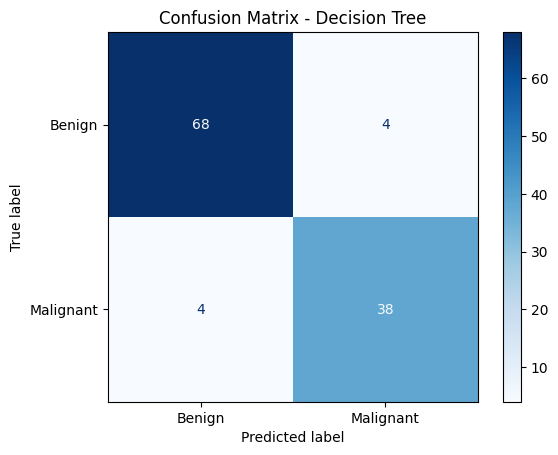

In [7]:
# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign","Malignant"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# **✅ Step 7 — ROC Curve & AUC (Graph)**

AUC Score (Decision Tree): 0.9246


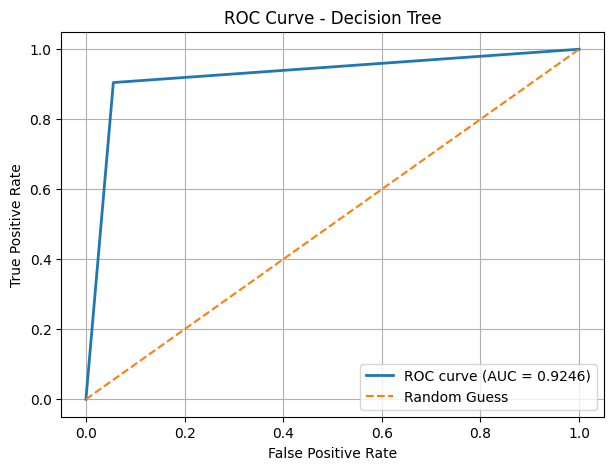

In [8]:
# Step 7: ROC & AUC
y_prob = dt.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC Score (Decision Tree): {roc_auc:.4f}")

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **✅ Step 8 — Feature Importance (Graph)**

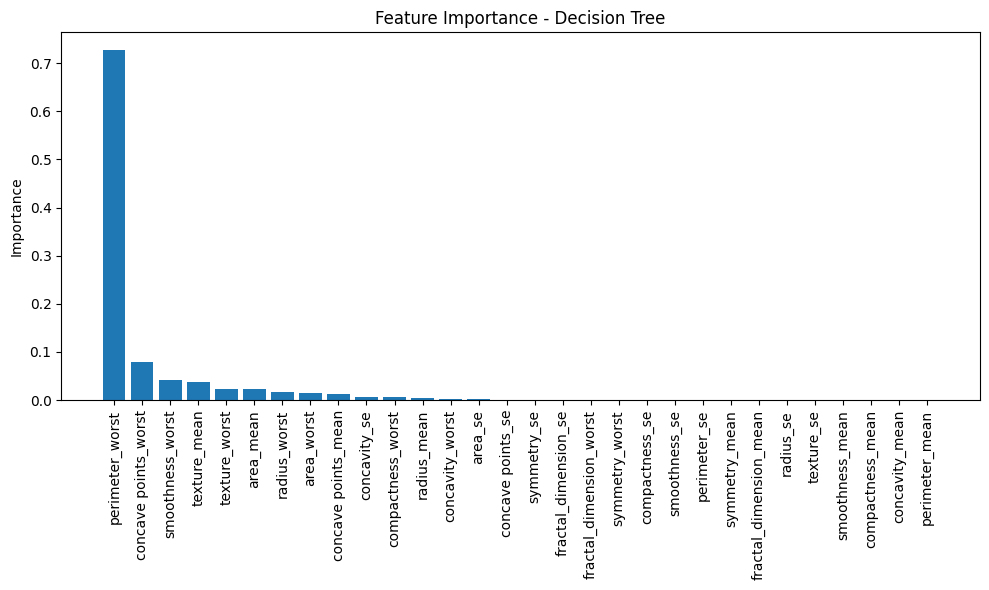

In [9]:
# Step 8: Feature Importances
import numpy as np

importances = dt.feature_importances_
idx_sorted = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(idx_sorted)), importances[idx_sorted], align="center")
plt.xticks(range(len(idx_sorted)), X.columns[idx_sorted], rotation=90)
plt.ylabel("Importance")
plt.title("Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()

# **✅ Step 9 — Visualize top 3 levels of the Tree (Graph)**

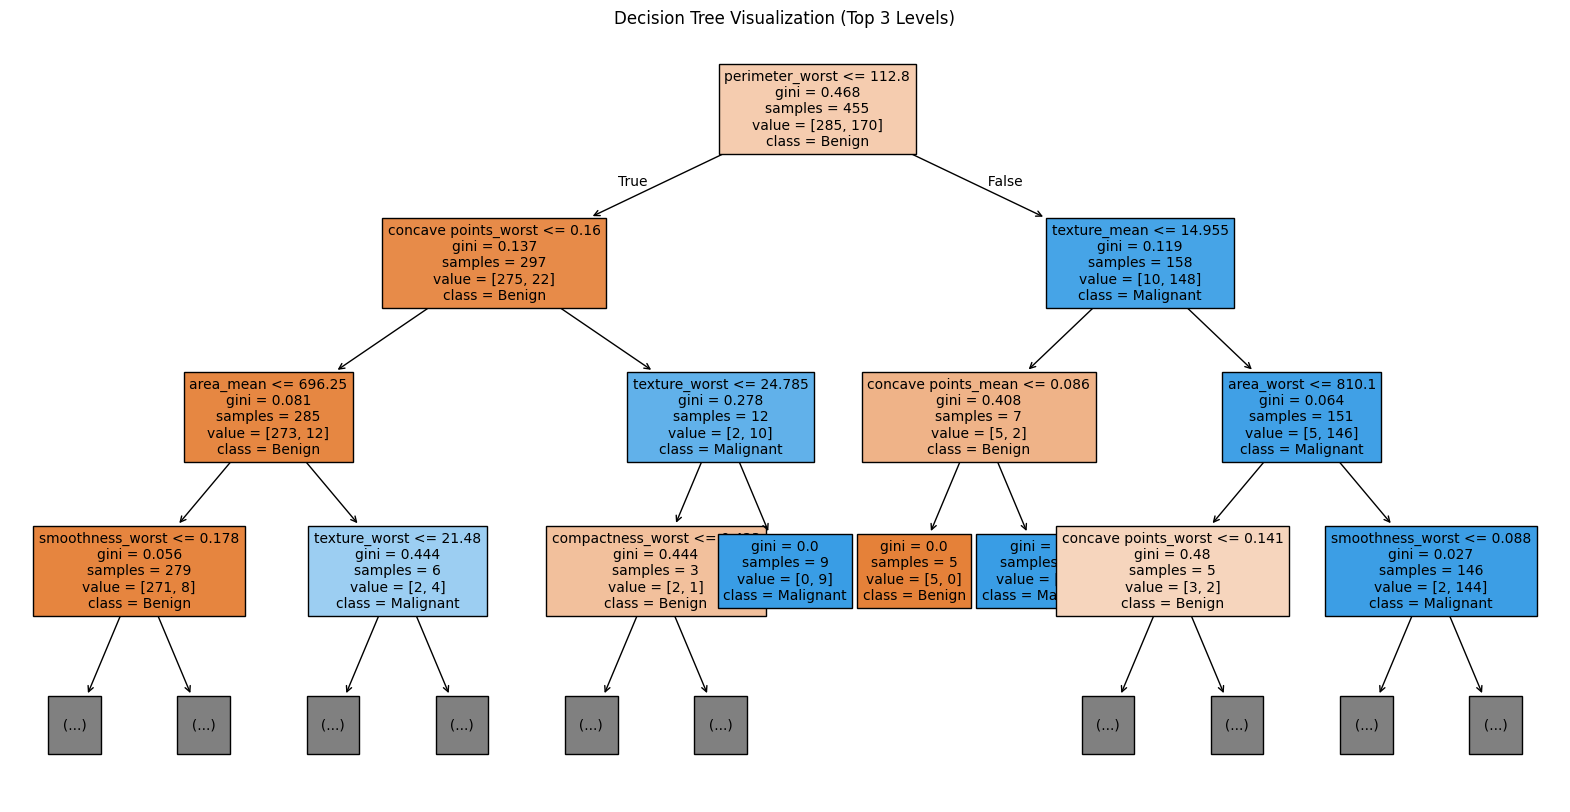

In [10]:
# Step 9: Visualize top levels of the tree
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X.columns,
    class_names=["Benign","Malignant"],
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

# **✅ Step 10 — Cross-Validation**

In [11]:
# Step 10: 10-fold CV accuracy on the whole dataset (baseline model)
cv_scores = cross_val_score(dt, X, y, cv=10, scoring="accuracy", n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.9280 ± 0.0327


# **✅ Step 11 — Hyperparameter Tuning with GridSearchCV**

In [12]:
# Step 11: Grid Search for best Decision Tree
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 4, 6, 8, 10, 12, 16, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": [None, "sqrt", "log2"]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid.best_params_)
print("✅ Best CV Accuracy:", grid.best_score_)

best_dt = grid.best_estimator_
y_pred_best = best_dt.predict(X_test)
best_acc = accuracy_score(y_test, y_pred_best)
print(f"\n🎯 Test Accuracy (Best DT): {best_acc * 100:.2f}%")
print("\nClassification Report (Best DT):\n", classification_report(y_test, y_pred_best, target_names=["Benign","Malignant"]))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits

✅ Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
✅ Best CV Accuracy: 0.9494505494505494

🎯 Test Accuracy (Best DT): 93.86%

Classification Report (Best DT):
               precision    recall  f1-score   support

      Benign       0.91      1.00      0.95        72
   Malignant       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



# **✅ Step 12 — Plots for the Best Model (Confusion Matrix & ROC)**

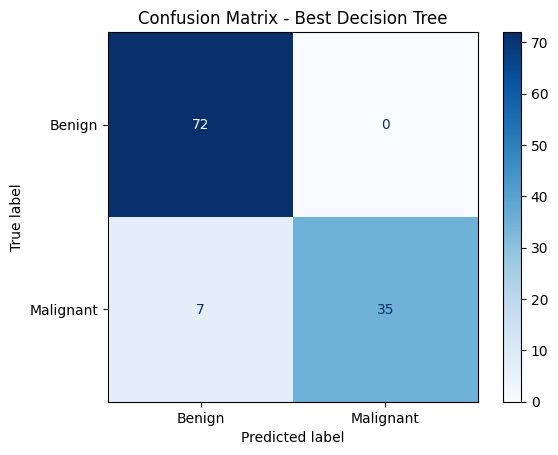

AUC Score (Best Decision Tree): 0.9507


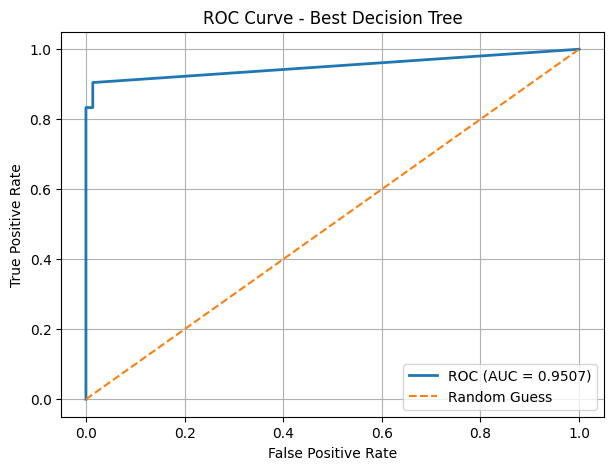

In [13]:
# Step 12A: Confusion Matrix for Best Model
cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["Benign","Malignant"])
disp_best.plot(cmap="Blues")
plt.title("Confusion Matrix - Best Decision Tree")
plt.show()

# Step 12B: ROC for Best Model
y_prob_best = best_dt.predict_proba(X_test)[:, 1]
fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_best)
auc_b = auc(fpr_b, tpr_b)
print(f"AUC Score (Best Decision Tree): {auc_b:.4f}")

plt.figure(figsize=(7,5))
plt.plot(fpr_b, tpr_b, linewidth=2, label=f'ROC (AUC = {auc_b:.4f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **✅ Step 13 — Save the Best Model & Download**

In [14]:
# Step 13: Save model to .joblib and download
import joblib
from google.colab import files

model_path = "decision_tree_best.joblib"
joblib.dump(best_dt, model_path)
print("Saved:", model_path)
files.download(model_path)

Saved: decision_tree_best.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **✅ Step 14 — Use the Saved Model for Predictions**

# A) Predict on a single example (using the test set’s first row as a template)

In [15]:
# Step 14A: Single example prediction demo
single = X_test.iloc[[0]].copy()
print("Sample features:\n", single)

loaded = joblib.load("decision_tree_best.joblib")
pred = loaded.predict(single)[0]
proba = loaded.predict_proba(single)[0,1]
print(f"\nPrediction: {pred}  (0=Benign, 1=Malignant)")
print(f"Probability of Malignant: {proba:.4f}")

Sample features:
      radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
120        11.41         10.82           73.34      403.3          0.09373   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
120           0.06685         0.03512              0.02623         0.1667   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
120                 0.06113  ...         12.82          15.97   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
120            83.74       510.5            0.1548              0.239   

     concavity_worst  concave points_worst  symmetry_worst  \
120           0.2102               0.08958          0.3016   

     fractal_dimension_worst  
120                  0.08523  

[1 rows x 30 columns]

Prediction: 0  (0=Benign, 1=Malignant)
Probability of Malignant: 0.0000


# B) Batch predictions on a new CSV that has SAME feature columns (no 'diagnosis')

In [17]:
# Step 14B: Batch predictions on a new CSV (upload a new file without 'diagnosis')
from google.colab import files
print("Upload a CSV with the SAME feature columns (no 'diagnosis') for batch prediction.")
uploaded2 = files.upload()

new_csv = None
for k in uploaded2.keys():
    if k.lower().endswith(".csv"):
        new_csv = k
        break

assert new_csv is not None, "Please upload a CSV."

new_df = pd.read_csv(new_csv)

# Keep only the numeric columns present in training features, in the same order
new_X = new_df.reindex(columns=X.columns).select_dtypes(include=[np.number])
new_X = new_X.fillna(new_X.median(numeric_only=True))

preds = loaded.predict(new_X)
probs = loaded.predict_proba(new_X)[:,1]

out = new_df.copy()
out["prediction"] = preds
out["prob_malignant"] = probs

out_path = "predictions.csv"
out.to_csv(out_path, index=False)
print("Saved predictions to:", out_path)
files.download(out_path)

Upload a CSV with the SAME feature columns (no 'diagnosis') for batch prediction.


Saving breast_cancer_without_diagnosis.csv to breast_cancer_without_diagnosis.csv
Saved predictions to: predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **✅ (Optional) Step 15 — Save your figures (PNG) to keep a record**

Saved: cm_best.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: roc_best.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved: feature_importance_best.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

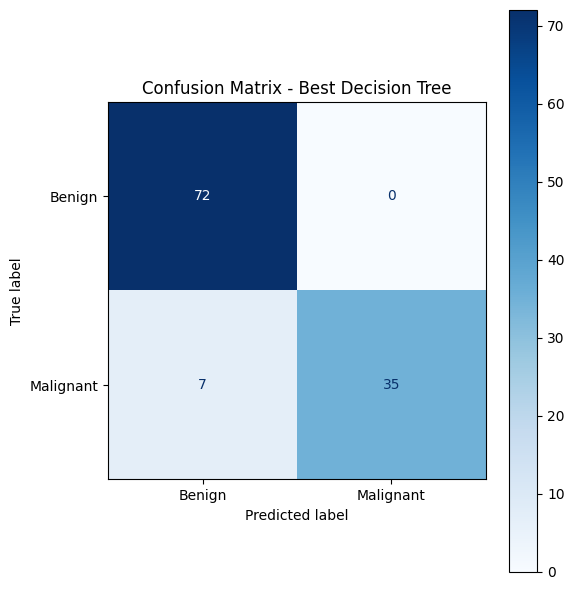

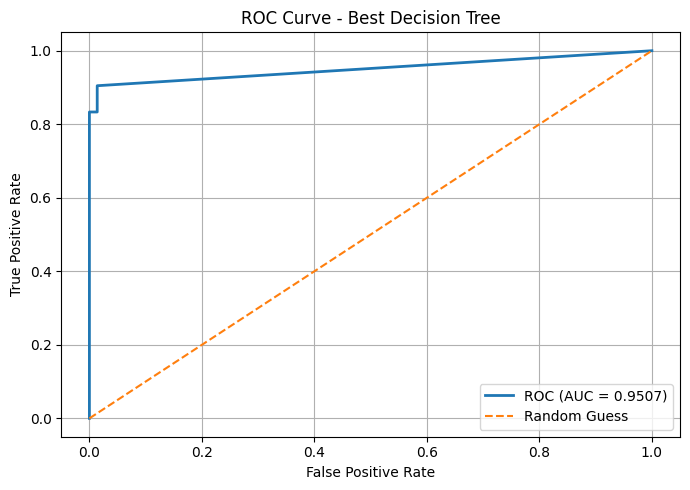

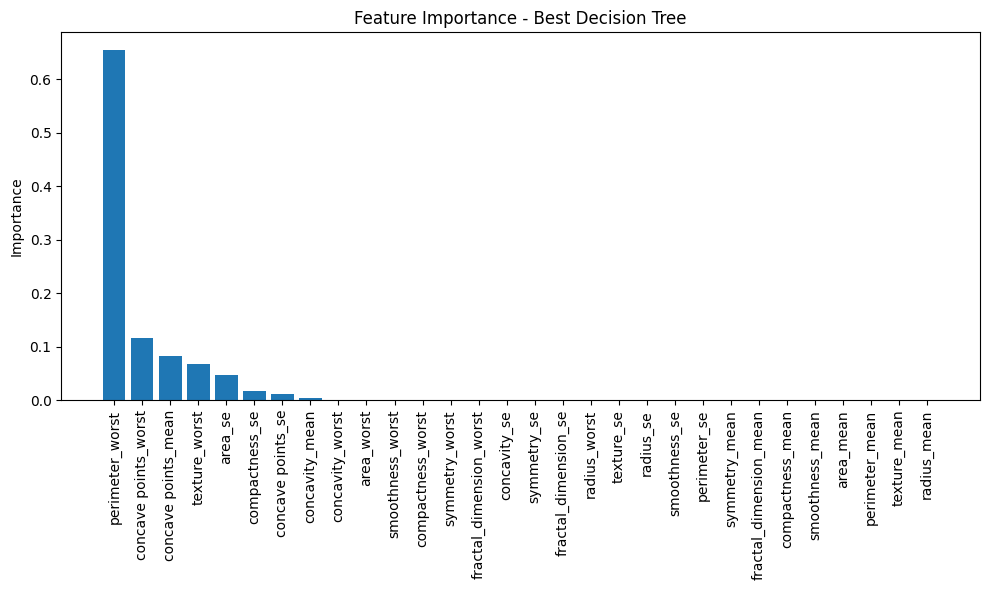

In [18]:
# Optional: Re-plot and save figures as PNG files for your report
figs = {}

# Confusion Matrix (Best)
cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["Benign","Malignant"])
fig_cm, ax_cm = plt.subplots(figsize=(6,6))
disp_best.plot(cmap="Blues", ax=ax_cm)
ax_cm.set_title("Confusion Matrix - Best Decision Tree")
figs["cm_best.png"] = fig_cm

# ROC (Best)
fig_roc, ax_roc = plt.subplots(figsize=(7,5))
ax_roc.plot(fpr_b, tpr_b, linewidth=2, label=f'ROC (AUC = {auc_b:.4f})')
ax_roc.plot([0,1], [0,1], linestyle='--', label='Random Guess')
ax_roc.set_xlabel('False Positive Rate'); ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve - Best Decision Tree')
ax_roc.legend(loc="lower right"); ax_roc.grid(True)
figs["roc_best.png"] = fig_roc

# Feature Importance (Best)
importances = best_dt.feature_importances_
idx_sorted = np.argsort(importances)[::-1]
fig_imp, ax_imp = plt.subplots(figsize=(10,6))
ax_imp.bar(range(len(idx_sorted)), importances[idx_sorted], align="center")
ax_imp.set_xticks(range(len(idx_sorted)))
ax_imp.set_xticklabels(X.columns[idx_sorted], rotation=90)
ax_imp.set_ylabel("Importance")
ax_imp.set_title("Feature Importance - Best Decision Tree")
figs["feature_importance_best.png"] = fig_imp

# Save and download
from google.colab import files
for name, fig in figs.items():
    fig.tight_layout()
    fig.savefig(name, dpi=150)
    print("Saved:", name)
    files.download(name)
plt.show()

# **Step 16 — Take User Input & Predict**

In [20]:
# 📂 Part 16.1: Upload your sample_input_data.txt file
from google.colab import files

print("📂 Please upload your 'sample_input_data.txt' file")
uploaded = files.upload()

# Get the uploaded file name+
file_name = list(uploaded.keys())[0]
print(f"✅ File Uploaded Successfully: {file_name}")

📂 Please upload your 'sample_input_data.txt' file


Saving 30 Sample Input Data.txt to 30 Sample Input Data (1).txt
✅ File Uploaded Successfully: 30 Sample Input Data (1).txt


# **Part 16.2 — Read Feature Values from TXT File**

In [21]:
# 📌 Part 16.2: Read feature values from TXT file
user_data = []

with open(file_name, "r") as f:
    for line in f:
        line = line.strip()
        # Ignore empty lines and comments starting with '#'
        if line and not line.startswith("#"):
            try:
                value = float(line.split(":")[1].strip())
                user_data.append(value)
            except:
                pass  # Skip invalid lines

print(f"✅ Successfully extracted {len(user_data)} feature values")


✅ Successfully extracted 30 feature values


# **Part 16.3 — Convert Data into NumPy Array**

In [22]:
# 🔹 Part 16.3: Convert user input data to NumPy array
import numpy as np

user_array = np.array(user_data).reshape(1, -1)
print("✅ User input converted to NumPy array")
print("📏 Shape:", user_array.shape)

✅ User input converted to NumPy array
📏 Shape: (1, 30)


# **Part 16.4 — Validate Feature Count**

In [23]:
# ✅ Part 16.4: Check if feature count matches dataset columns
expected_features = len(X.columns)

if user_array.shape[1] != expected_features:
    print(f"⚠️ ERROR: Expected {expected_features} features but got {user_array.shape[1]}.")
    print("Please check your TXT file.")
else:
    print("✅ Feature count matches the dataset. Proceeding with prediction...")

✅ Feature count matches the dataset. Proceeding with prediction...


# **Part 16.5 — Predict Diagnosis**

In [24]:
# 🎯 Part 16.5: Make prediction using the best trained Decision Tree
if user_array.shape[1] == expected_features:
    prediction = best_dt.predict(user_array)
    probability = best_dt.predict_proba(user_array)[0][1] * 100  # Probability of malignant

    print("\n================= PREDICTION RESULT =================")
    if prediction[0] == 1:
        print(f"🔴 Diagnosis: Malignant (Cancerous)")
        print(f"📊 Probability of Malignancy: {probability:.2f}%")
    else:
        print(f"🟢 Diagnosis: Benign (Non-cancerous)")
        print(f"📊 Probability of Malignancy: {probability:.2f}%")
    print("=====================================================")



================= PREDICTION RESULT =================
🟢 Diagnosis: Benign (Non-cancerous)
📊 Probability of Malignancy: 0.00%


# **Step 17 — Interactive Breast Cancer Prediction Form**

# Part 17.1 — Install & Import Required Libraries

In [25]:
# Part 17.1: Install & Import Required Libraries
!pip install ipywidgets --quiet

import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.4 MB/s eta 0:00:00


# Part 17.2 — Create Interactive Input Fields

In [26]:
# Part 17.2: Create sliders & textboxes for all features dynamically
feature_widgets = {}

print("🔹 Please provide feature values for prediction:")

for feature in X.columns:
    # Create slider with default range
    slider = widgets.FloatText(
        value=0.0,
        description=feature,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='400px')
    )
    feature_widgets[feature] = slider
    display(slider)


🔹 Please provide feature values for prediction:


FloatText(value=0.0, description='radius_mean', layout=Layout(width='400px'), style=DescriptionStyle(descripti…

FloatText(value=0.0, description='texture_mean', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='perimeter_mean', layout=Layout(width='400px'), style=DescriptionStyle(descri…

FloatText(value=0.0, description='area_mean', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='smoothness_mean', layout=Layout(width='400px'), style=DescriptionStyle(descr…

FloatText(value=0.0, description='compactness_mean', layout=Layout(width='400px'), style=DescriptionStyle(desc…

FloatText(value=0.0, description='concavity_mean', layout=Layout(width='400px'), style=DescriptionStyle(descri…

FloatText(value=0.0, description='concave points_mean', layout=Layout(width='400px'), style=DescriptionStyle(d…

FloatText(value=0.0, description='symmetry_mean', layout=Layout(width='400px'), style=DescriptionStyle(descrip…

FloatText(value=0.0, description='fractal_dimension_mean', layout=Layout(width='400px'), style=DescriptionStyl…

FloatText(value=0.0, description='radius_se', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='texture_se', layout=Layout(width='400px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='perimeter_se', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='area_se', layout=Layout(width='400px'), style=DescriptionStyle(description_w…

FloatText(value=0.0, description='smoothness_se', layout=Layout(width='400px'), style=DescriptionStyle(descrip…

FloatText(value=0.0, description='compactness_se', layout=Layout(width='400px'), style=DescriptionStyle(descri…

FloatText(value=0.0, description='concavity_se', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='concave points_se', layout=Layout(width='400px'), style=DescriptionStyle(des…

FloatText(value=0.0, description='symmetry_se', layout=Layout(width='400px'), style=DescriptionStyle(descripti…

FloatText(value=0.0, description='fractal_dimension_se', layout=Layout(width='400px'), style=DescriptionStyle(…

FloatText(value=0.0, description='radius_worst', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='texture_worst', layout=Layout(width='400px'), style=DescriptionStyle(descrip…

FloatText(value=0.0, description='perimeter_worst', layout=Layout(width='400px'), style=DescriptionStyle(descr…

FloatText(value=0.0, description='area_worst', layout=Layout(width='400px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='smoothness_worst', layout=Layout(width='400px'), style=DescriptionStyle(desc…

FloatText(value=0.0, description='compactness_worst', layout=Layout(width='400px'), style=DescriptionStyle(des…

FloatText(value=0.0, description='concavity_worst', layout=Layout(width='400px'), style=DescriptionStyle(descr…

FloatText(value=0.0, description='concave points_worst', layout=Layout(width='400px'), style=DescriptionStyle(…

FloatText(value=0.0, description='symmetry_worst', layout=Layout(width='400px'), style=DescriptionStyle(descri…

FloatText(value=0.0, description='fractal_dimension_worst', layout=Layout(width='400px'), style=DescriptionSty…

# Part 17.3 — Create Prediction Button

In [27]:
# Part 17.3: Create a button to predict diagnosis
predict_button = widgets.Button(
    description="🔮 Predict Diagnosis",
    button_style="success",
    layout=widgets.Layout(width='300px')
)

output_box = widgets.Output()

def on_predict_clicked(b):
    with output_box:
        clear_output()  # Clear previous output

        # Collect all user inputs into a list
        user_data = [feature_widgets[feature].value for feature in X.columns]
        user_array = np.array(user_data).reshape(1, -1)

        # Make prediction
        prediction = best_dt.predict(user_array)
        probability = best_dt.predict_proba(user_array)[0][1] * 100

        print("=====================================================")
        if prediction[0] == 1:
            print(f"🔴 Diagnosis: Malignant (Cancerous)")
            print(f"📊 Probability of Malignancy: {probability:.2f}%")
        else:
            print(f"🟢 Diagnosis: Benign (Non-cancerous)")
            print(f"📊 Probability of Malignancy: {probability:.2f}%")
        print("=====================================================")

predict_button.on_click(on_predict_clicked)
display(predict_button, output_box)

Button(button_style='success', description='🔮 Predict Diagnosis', layout=Layout(width='300px'), style=ButtonSt…

Output()

# **Step 18 — Web App Deployment using Gradio**

# Part 18.1 — Install Gradio

In [28]:
# Part 18.1: Install Gradio
!pip install gradio --quiet

# Part 18.2 — Import Libraries & Setup

In [29]:
# Part 18.2: Import required libraries
import gradio as gr
import numpy as np

# Part 18.3 — Create Prediction Function

In [30]:
# Part 18.3: Define prediction function
def predict_breast_cancer(*inputs):
    # Convert inputs into numpy array
    user_array = np.array(inputs).reshape(1, -1)

    # Predict using trained model
    prediction = best_dt.predict(user_array)
    probability = best_dt.predict_proba(user_array)[0][1] * 100

    # Return results
    if prediction[0] == 1:
        return "🔴 Malignant (Cancerous)", f"📊 Probability: {probability:.2f}%"
    else:
        return "🟢 Benign (Non-cancerous)", f"📊 Probability: {probability:.2f}%"

# Part 18.4 — Build the Gradio Interface


In [31]:
# Part 18.4: Build Gradio interface dynamically based on dataset features

# Create input components dynamically based on features in X
inputs = []
for feature in X.columns:
    inputs.append(gr.Number(label=feature))

# Define Gradio interface
interface = gr.Interface(
    fn=predict_breast_cancer,
    inputs=inputs,
    outputs=[
        gr.Label(label="Diagnosis Result"),
        gr.Label(label="Probability")
    ],
    title="🔮 Breast Cancer Prediction App",
    description="Enter the feature values below to predict whether the tumor is Benign or Malignant."
)

# Launch the app
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b1fb501b10b819cc50.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Step 19 :**Interactive Dashboard for Breast Cancer Prediction****

# **Step 19.1 :— Install & Import Required Libraries**

In [32]:
# step 19.1: Install required libraries
!pip install plotly --quiet

# Import libraries
import plotly.graph_objects as go
import plotly.subplots as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import numpy as np

# **Step 19.2 : Model Evaluation Metrics**

In [33]:
# Step 19.2 : Evaluate the best Decision Tree model
y_pred_best = best_dt.predict(X_test)
y_probs_best = best_dt.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, y_pred_best)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_best))

✅ Model Accuracy: 0.9386

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        72
           1       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



# **Step 19.3 : Confusion Matrix Visualization**

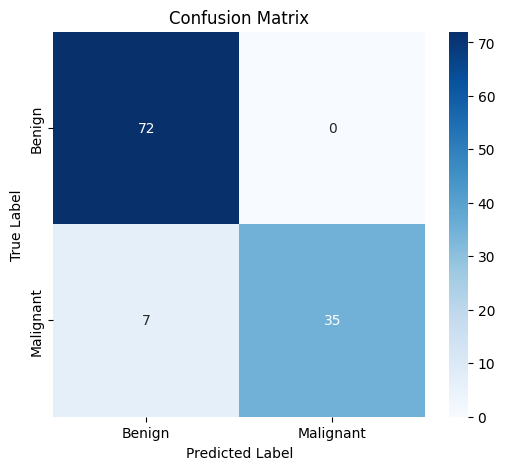

In [34]:
# Step 19.3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
labels = ["Benign", "Malignant"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **Step 19.4 — ROC Curve & AUC Score**

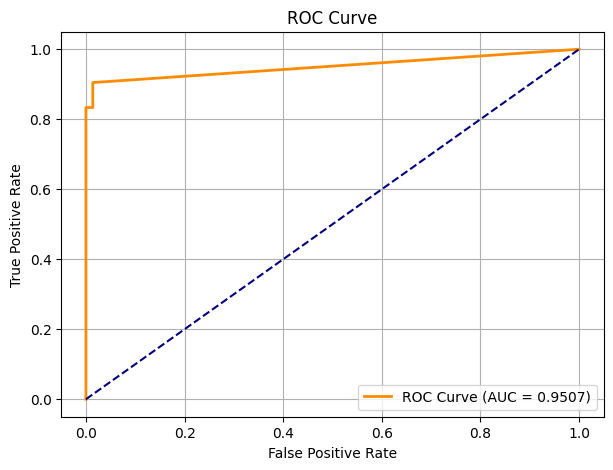

In [35]:
# step 19.4: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Part 19.5 — Feature Importance Visualization**

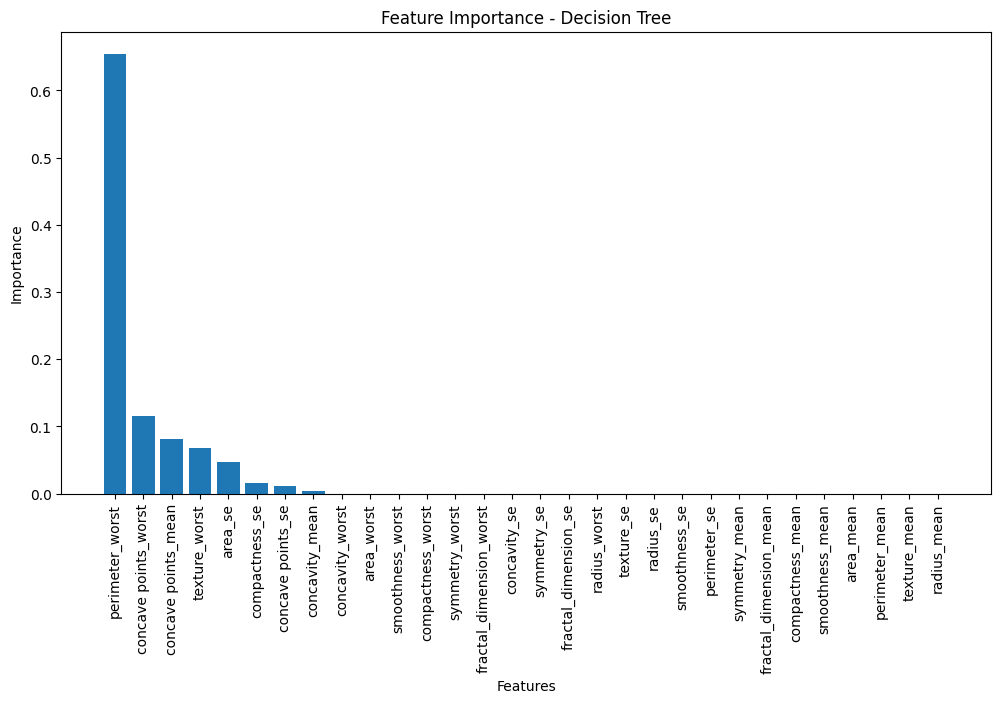

In [36]:
# step 19.5: Feature Importance from Best Decision Tree
importances = best_dt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - Decision Tree")
plt.show()

# **Part 19.6 — Interactive Plotly Dashboard**

In [37]:
# step 19.6: Interactive ROC Curve using Plotly
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("ROC Curve", "Feature Importance"))

# ROC Curve
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC Curve (AUC={roc_auc:.4f})", line=dict(color="orange")),
    row=1, col=1
)

# Diagonal line
fig.add_trace(
    go.Scatter(x=[0,1], y=[0,1], mode="lines", name="Random Guess", line=dict(color="blue", dash="dash")),
    row=1, col=1
)

# Feature Importance
fig.add_trace(
    go.Bar(
        x=X.columns[indices],
        y=importances[indices],
        marker=dict(color="green")
    ),
    row=1, col=2
)

fig.update_layout(
    title="Interactive Dashboard - Breast Cancer Prediction",
    height=600,
    width=1000,
    showlegend=True
)
fig.show()
